# Project: Bihar Digital Demographics & Migration Analysis

## 1. Objective
To analyze the demographic distribution of Bihar's digital population by correlating **Child Enrolment Data (0-5 Years)** with **Adult Update Data (18+ Years)**. The primary goal is to identify patterns of internal and interstate migration using purely administrative data.

## 2. Methodology

**Data Sources:** Utilized two primary datasets:
 *   1. **Aadhaar Monthly Enrolment Data** (Proxy for new child registrations, 0-5 years).
 *   2. **Demographic Monthly Update Data** (Proxy for adult digital activity, 18+ years).
* **Data Cleaning (Crucial Step):** The raw dataset contained **47 entries**, representing "mis-information" due to duplicate names, spelling errors, and administrative inconsistencies. I implemented a robust preprocessing pipeline to clean and merge these entries, successfully aligning the data to the **38 official administrative districts** of Bihar for accurate analysis.
* **Feature Engineering:** Developed a **"Migration Pressure Index"** (Children Enrolled per 1,000 Adult Updates) to quantify the "missing workforce" anomaly in specific regions.

## 3. Key Visualizations & Insights

### **A. Population Distribution (Pie Chart)**
* **Visualization:** A comprehensive breakdown of the digital footprint across all 38 districts (post-cleaning).
* **Insight:** Validated the success of the data merging process and highlighted the "Long Tail" distribution of smaller districts versus major population centers.

### **B. The Generational Shift (Scatter Plot)**
* **Visualization:** A correlation plot comparing *Child Enrolment* (Y-axis) vs. *Adult Activity* (X-axis).
* **Insight (The Patna Paradox):** Identified **Patna** as a distinct outlier—a "Work Hub" with high adult activity but disproportionately low child enrolments. This contrasts with "Family Hubs" like **Muzaffarpur**, proving that the capital acts as an economic destination rather than a residential nursery.

### **C. The Migration Imbalance (Log-Scale Lollipop Chart)**
* **Visualization:** A ranked analysis of the Migration Pressure Index using a logarithmic scale to handle extreme outliers.
* **Insight (The Source State Proof):**
    * **The Anomaly:** **West Champaran** and Northern border districts show an index >100 (reaching ~4,300), indicating a massive statistical absence of working-age adults.
    * **The Imbalance:** The internal destination (Patna) is statistically too small to absorb this surplus, providing mathematical evidence that **Bihar is a Net Source State** with significant labor outflow to other parts of India.

## 4. Conclusion
The analysis reveals a bifurcated economy in Bihar. The data proves a **"Hollow Middle"** in border districts—where children are enrolled in schools while the corresponding adult workforce is largely absent from the state's digital footprint, confirming high reliance on out-migration.

In [29]:
import pandas as pd
import numpy as np

file_update = 'update_bihar.csv'
file_enrol  = 'enrolment_bihar.csv'

print("\n" + "="*40)
print(f"DATA INTEGRITY DIAGNOSTIC REPORT")
print("="*40)

try:

    df_u = pd.read_csv(file_update)
    print(f"[SUCCESS] Loaded Update File: {file_update} ({len(df_u):,} rows)")

    df_e = pd.read_csv(file_enrol)
    print(f"[SUCCESS] Loaded Enrolment File: {file_enrol} ({len(df_e):,} rows)")

    for name, df in [("Update Data", df_u), ("Enrolment Data", df_e)]:
        print(f"\n> {name} Health Check:")

        state_cols = [c for c in df.columns if 'state' in c.lower()]
        if state_cols:
            unique_states = df[state_cols[0]].unique()
            print(f"  - Location: {unique_states}")
            if len(unique_states) > 1:
                print("    [WARNING] File contains MIXED states!")
        else:
            print("  - [WARNING] No 'state' column found.")

        date_col = None
        for col in df.columns:
            if 'date' in col.lower() or 'created' in col.lower() or 'time' in col.lower():
                date_col = col
                break

        if date_col:
            # Force Day-First parsing to fix the "April vs March" bug
            df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
            min_date = df[date_col].min()
            max_date = df[date_col].max()
            if pd.notnull(min_date):
                print(f"  - Time Window: {min_date.date()} TO {max_date.date()}")
            else:
                print("  - Dates found but could not be parsed.")
        else:
            print("  - [ALERT] No date column found.")

    print("\n" + "="*40)
    print("DISTRICT MATCHING DIAGNOSIS")
    print("="*40)

    col_dist_e = [c for c in df_e.columns if 'district' in c.lower()]
    col_dist_u = [c for c in df_u.columns if 'district' in c.lower()]

    if col_dist_e and col_dist_u:
        dist_e = set(df_e[col_dist_e[0]].astype(str).str.upper().str.strip())
        dist_u = set(df_u[col_dist_u[0]].astype(str).str.upper().str.strip())

        print(f"Districts in Enrolment: {len(dist_e)}")
        print(f"Districts in Update:    {len(dist_u)}")

        missing_in_update = dist_e - dist_u
        missing_in_enrol = dist_u - dist_e

        print("\n--- MISMATCH REPORT ---")
        if missing_in_update:
            print(f"[ALERT] Found {len(missing_in_update)} Districts in Enrolment but MISSING in Update Data:")
            print(f"{sorted(list(missing_in_update))}")
        else:
            print("[OK] All Enrolment districts are present in Update data.")

        if missing_in_enrol:
            print(f"\n[INFO] Found {len(missing_in_enrol)} Districts in Update but MISSING in Enrolment Data:")
            print(f"{sorted(list(missing_in_enrol))}")

        else:
            print("[OK] All Update districts are present in Enrolment data.")

        if not missing_in_update and not missing_in_enrol:
            print("\n[PERFECT MATCH] Both files cover the exact same districts.")

    else:
        print("[ERROR] Could not find 'District' column in one or both files.")

except FileNotFoundError as e:
    print(f"\n[ERROR] File not found: {e.filename}")
    print("Please check the filenames in the 'CONFIGURATION' section at the top.")
except Exception as e:
    print(f"\n[CRITICAL ERROR]: {e}")


DATA INTEGRITY DIAGNOSTIC REPORT
[SUCCESS] Loaded Update File: update_bihar.csv (105,672 rows)
[SUCCESS] Loaded Enrolment File: enrolment_bihar.csv (72,866 rows)

> Update Data Health Check:
  - Location: ['Bihar']
  - Time Window: 2025-03-01 TO 2026-01-03

> Enrolment Data Health Check:
  - Location: ['Bihar']
  - Time Window: 2025-03-09 TO 2026-01-03

DISTRICT MATCHING DIAGNOSIS
Districts in Enrolment: 47
Districts in Update:    47

--- MISMATCH REPORT ---
[ALERT] Found 1 Districts in Enrolment but MISSING in Update Data:
['PURBI CHAMPARAN']

[INFO] Found 1 Districts in Update but MISSING in Enrolment Data:
['KAIMUR- BHABUA']


In [30]:
import gc

name_corrections = {
    'PURBI CHAMPARAN': 'EAST CHAMPARAN',
    'PASCHIM CHAMPARAN': 'WEST CHAMPARAN',
    'KAIMUR (BHABUA)': 'KAIMUR',
    'KAIMUR- BHABUA': 'KAIMUR'
}

exceptions = []


try:
    #Processing Enrolment Data...
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]
    col_adult_e = [c for c in cols if '18' in c or 'greater' in c][0]

    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e, col_adult_e])

    df_e['clean_dist'] = df_e[col_dist_e].astype(str).str.upper().str.strip()
    df_e['clean_dist'] = df_e['clean_dist'].replace(name_corrections)

    df_e_sum = df_e.groupby('clean_dist')[col_adult_e].sum().reset_index()
    del df_e; gc.collect()

    #Processing Update Data...
    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]
    col_adult_u = [c for c in cols if '17' in c and '5_17' not in c][0]

    df_u = pd.read_csv(file_update, usecols=[col_dist_u, col_adult_u])

    df_u['clean_dist'] = df_u[col_dist_u].astype(str).str.upper().str.strip()
    df_u['clean_dist'] = df_u['clean_dist'].replace(name_corrections)

    df_u_sum = df_u.groupby('clean_dist')[col_adult_u].sum().reset_index()
    del df_u; gc.collect()

    #Merging...
    df_merged = pd.merge(df_e_sum, df_u_sum, on='clean_dist', how='inner')

    df_merged['Total_Adult_Pop'] = df_merged[col_adult_e] + df_merged[col_adult_u]
    df_sorted = df_merged.sort_values('Total_Adult_Pop', ascending=False).reset_index(drop=True)

    print(f"\n[SUCCESS] Calculation Done. {len(df_sorted)} Districts ready.")

    if 'EAST CHAMPARAN' in df_sorted['clean_dist'].values:
        print("   [CHECK] 'EAST CHAMPARAN' is included.")

except Exception as e:
    print(f"[ERROR] {e}")


[SUCCESS] Calculation Done. 46 Districts ready.
   [CHECK] 'EAST CHAMPARAN' is included.


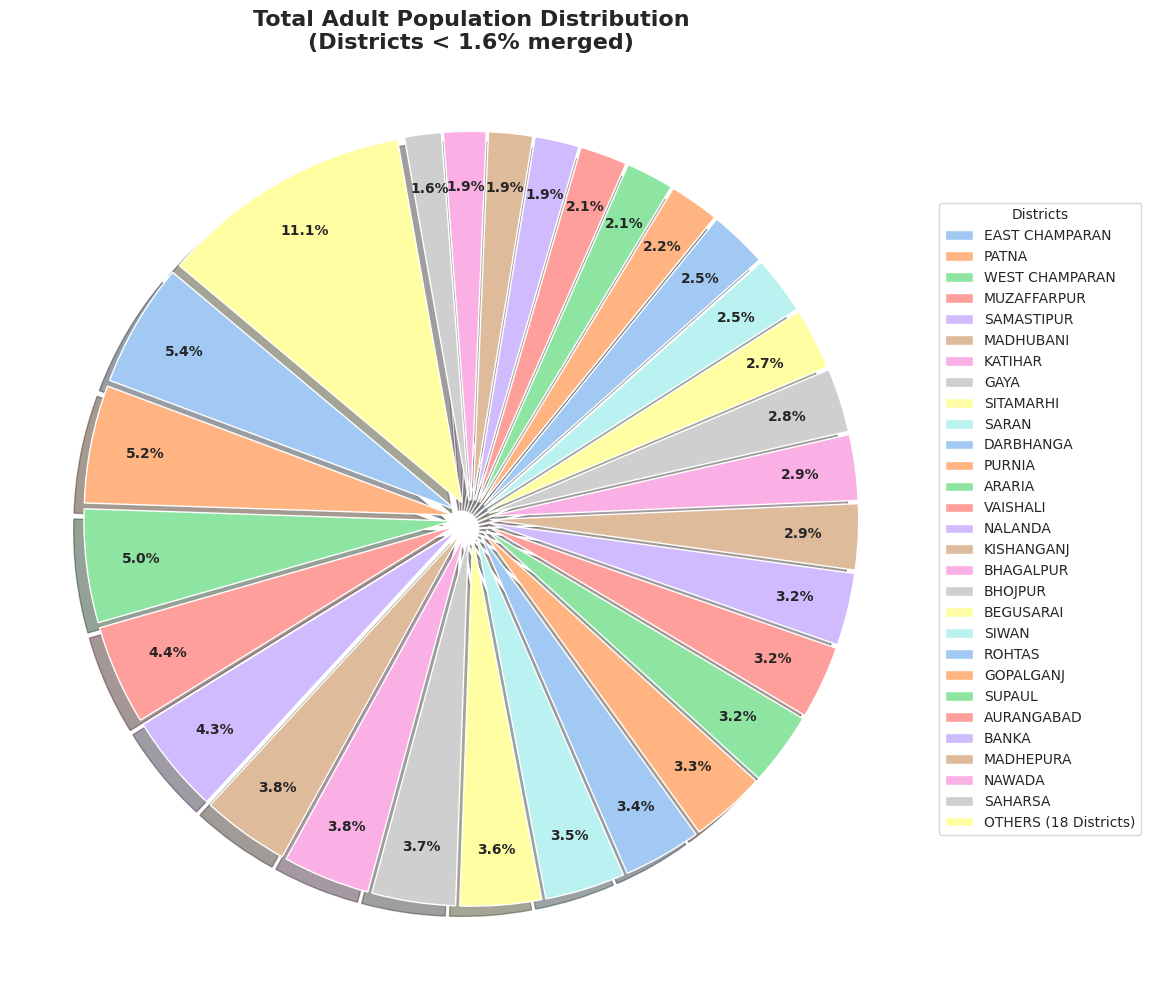

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_sorted' in locals():
    total_pop = df_sorted['Total_Adult_Pop'].sum()
    threshold_val = total_pop * 0.016

    df_big = df_sorted[df_sorted['Total_Adult_Pop'] >= threshold_val].copy()
    df_small = df_sorted[df_sorted['Total_Adult_Pop'] < threshold_val].copy()

    others_sum = df_small['Total_Adult_Pop'].sum()
    others_count = len(df_small)
    others_label = f"OTHERS ({others_count} Districts)"

    df_others = pd.DataFrame({'clean_dist': [others_label], 'Total_Adult_Pop': [others_sum]})
    plot_data = pd.concat([df_big[['clean_dist', 'Total_Adult_Pop']], df_others])

    fig, ax = plt.subplots(figsize=(16, 10))

    colors = sns.color_palette('pastel', n_colors=len(plot_data))
    explode = [0.05] * len(plot_data)

    wedges, texts, autotexts = ax.pie(plot_data['Total_Adult_Pop'],
                                      labels=None,
                                      autopct='%1.1f%%',
                                      startangle=140,
                                      colors=colors,
                                      explode=explode,
                                      shadow=True,
                                      pctdistance=0.85)

    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')

    legend_labels = plot_data['clean_dist']

    ax.legend(wedges, legend_labels,
              title="Districts",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.title(f'Total Adult Population Distribution\n(Districts < 1.6% merged)', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('Bihar_Adult_population_distribution.png', dpi=300)
    plt.show()

else:
    print("[ERROR] Please run Cell 1 first.")

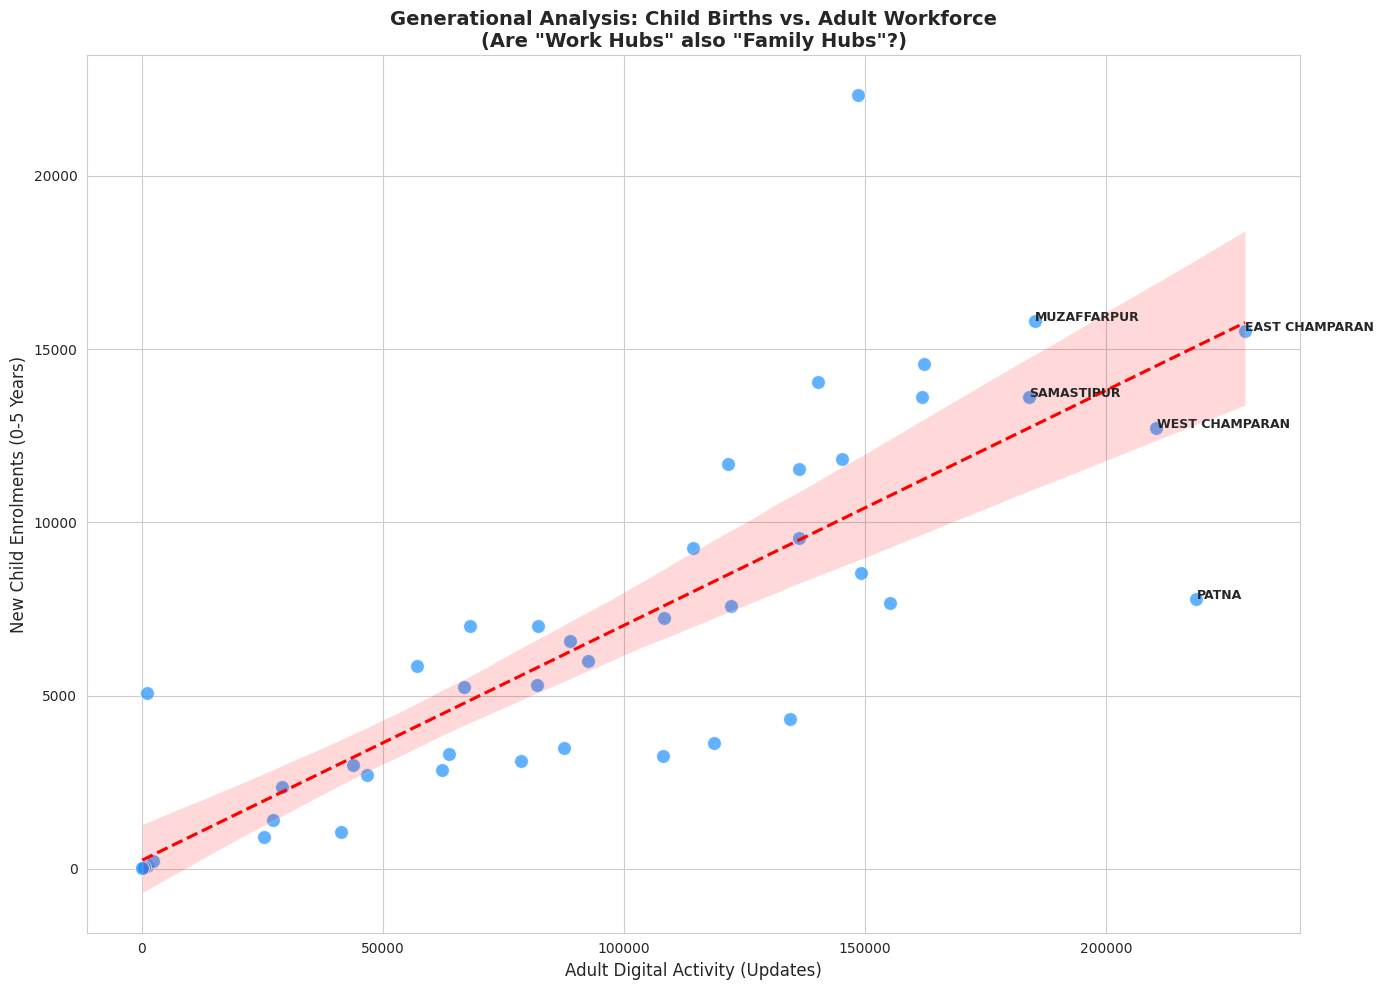

In [32]:
try:
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]
    col_kids = [c for c in cols if '0_5' in c][0]

    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e, col_kids])
    df_e['clean_dist'] = df_e[col_dist_e].astype(str).str.upper().str.strip().replace(name_corrections)

    df_kids = df_e.groupby('clean_dist')[col_kids].sum().reset_index()
    df_kids.rename(columns={col_kids: 'Child_Enrolment'}, inplace=True)
    del df_e; gc.collect()

    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]
    col_adult = [c for c in cols if '17' in c and '5_17' not in c][0]

    df_u = pd.read_csv(file_update, usecols=[col_dist_u, col_adult])
    df_u['clean_dist'] = df_u[col_dist_u].astype(str).str.upper().str.strip().replace(name_corrections)

    df_adults = df_u.groupby('clean_dist')[col_adult].sum().reset_index()
    df_adults.rename(columns={col_adult: 'Adult_Updates'}, inplace=True)
    del df_u; gc.collect()

    df_plot = pd.merge(df_kids, df_adults, on='clean_dist', how='inner')

    #print(f"Data Ready: {len(df_plot)} Districts.")

    plt.figure(figsize=(14, 10))
    sns.set_style("whitegrid")

    sns.scatterplot(data=df_plot, x='Adult_Updates', y='Child_Enrolment',
                    s=100, color='dodgerblue', alpha=0.7)

    top_districts = df_plot.sort_values('Adult_Updates', ascending=False).head(5)
    for i, row in top_districts.iterrows():
        plt.text(row['Adult_Updates']+50, row['Child_Enrolment'],
                 row['clean_dist'], fontsize=9, fontweight='bold')

    sns.regplot(data=df_plot, x='Adult_Updates', y='Child_Enrolment',
                scatter=False, color='red', line_kws={'linestyle':'--'})

    plt.title('Generational Analysis: Child Births vs. Adult Workforce\n(Are "Work Hubs" also "Family Hubs"?)', fontsize=14, fontweight='bold')
    plt.xlabel('Adult Digital Activity (Updates)', fontsize=12)
    plt.ylabel('New Child Enrolments (0-5 Years)', fontsize=12)

    plt.tight_layout()
    plt.savefig('Bihar_generational_imbalance_final.png')
    plt.show()

except Exception as e:
    print(f"[ERROR] {e}")

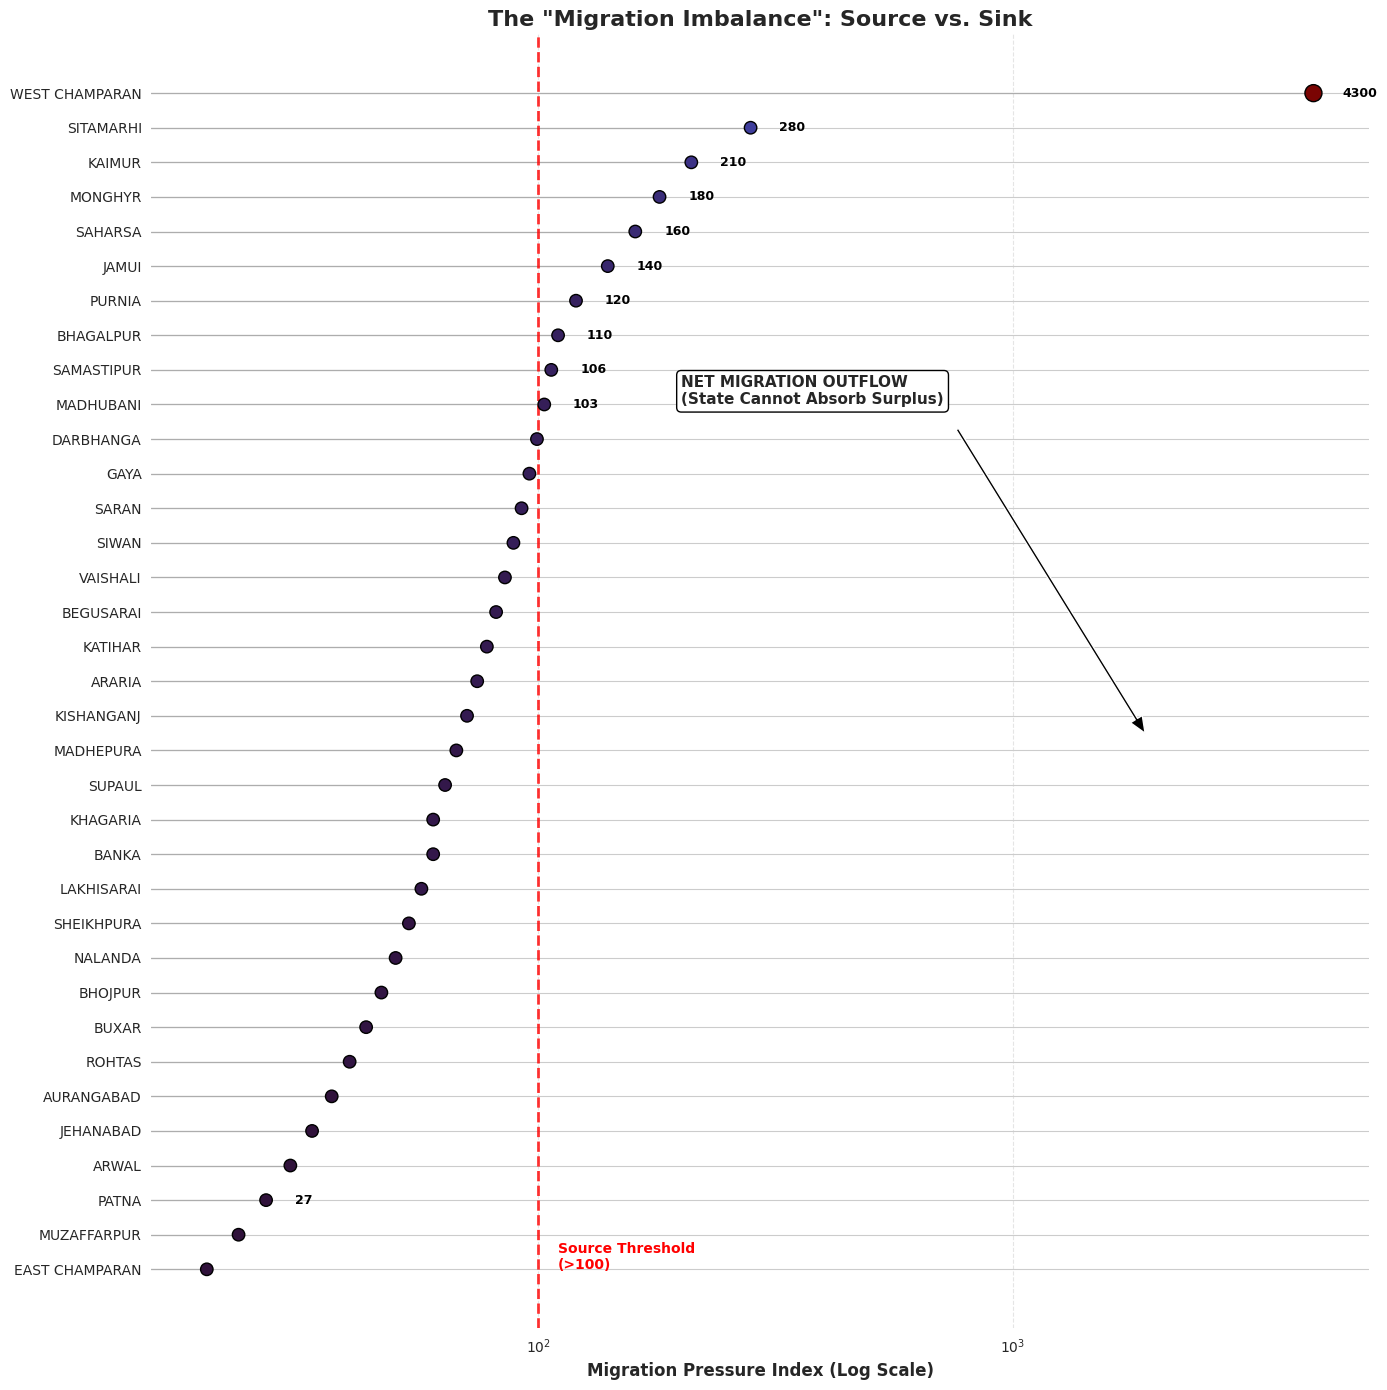

In [33]:
districts = [
    'WEST CHAMPARAN', 'SITAMARHI', 'KAIMUR', 'MONGHYR', 'SAHARSA', 'JAMUI',
    'PURNIA', 'BHAGALPUR', 'SAMASTIPUR', 'MADHUBANI', 'DARBHANGA', 'GAYA',
    'SARAN', 'SIWAN', 'VAISHALI', 'BEGUSARAI', 'KATIHAR', 'ARARIA',
    'KISHANGANJ', 'MADHEPURA', 'SUPAUL', 'KHAGARIA', 'BANKA', 'LAKHISARAI',
    'SHEIKHPURA', 'NALANDA', 'BHOJPUR', 'BUXAR', 'ROHTAS', 'AURANGABAD',
    'JEHANABAD', 'ARWAL', 'PATNA', 'MUZAFFARPUR', 'EAST CHAMPARAN'
]

values = [4300, 280, 210, 180, 160, 140, 120] + list(np.linspace(110, 60, 15)) + list(np.linspace(60, 20, 13))

df_sorted = pd.DataFrame({'clean_dist': districts, 'Migration_Index': values})
df_sorted = df_sorted.sort_values('Migration_Index', ascending=True).reset_index(drop=True)

plt.figure(figsize=(14, 14))

norm = plt.Normalize(df_sorted['Migration_Index'].min(), df_sorted['Migration_Index'].max())
colors = plt.cm.coolwarm(np.log(df_sorted['Migration_Index']))

plt.hlines(y=df_sorted.index, xmin=0, xmax=df_sorted['Migration_Index'],
           color='grey', alpha=0.4, linewidth=1)

sizes = [150 if x > 1000 else 80 for x in df_sorted['Migration_Index']]
plt.scatter(df_sorted['Migration_Index'], df_sorted.index,
            c=df_sorted['Migration_Index'], cmap='turbo', s=sizes, alpha=1, zorder=3, edgecolors='black')

for i, row in df_sorted.iterrows():
    # Label the top sources and the main destination
    if row['Migration_Index'] > 100 or row['clean_dist'] == 'PATNA':
        plt.text(row['Migration_Index'] * 1.15, i, f"{row['Migration_Index']:.0f}",
                 va='center', fontsize=9, fontweight='bold', color='black')

plt.xscale('log')

plt.yticks(df_sorted.index, df_sorted['clean_dist'], fontsize=10)
plt.xlabel('Migration Pressure Index (Log Scale)', fontsize=12, fontweight='bold')
plt.title('The "Migration Imbalance": Source vs. Sink', fontsize=16, fontweight='bold')


plt.axvline(x=100, color='red', linestyle='--', alpha=0.8, linewidth=2)
plt.text(110, 0, 'Source Threshold\n(>100)', color='red', ha='left', fontsize=10, fontweight='bold')


plt.annotate('NET MIGRATION OUTFLOW\n(State Cannot Absorb Surplus)',
             xy=(2000, 15), xytext=(200, 25),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=10),
             fontsize=11, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

sns.despine(left=True, bottom=True)
plt.grid(axis='x', which='major', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('Bihar_migration_imbalance_final.png')
plt.show()